In [23]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from textblob import TextBlob

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from collections import Counter
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
import optuna

from sklearn.feature_selection import SelectKBest, f_regression, RFE, mutual_info_classif


# Data

In [24]:
# Load the datasets
orders = pd.read_csv('data/olist_orders_dataset.csv')
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
sellers = pd.read_csv('data/olist_sellers_dataset.csv')
geolocation = pd.read_csv('data/olist_geolocation_dataset.csv')
customers = pd.read_csv('data/olist_customers_dataset.csv')
payments = pd.read_csv('data/olist_order_payments_dataset.csv')
reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')

In [25]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [26]:
# orders - orde placed dates, delivery dates, estimated_dates - order_id unique
# order_items - order price and freight value - order_id, order_item_id(sequential number for total items in order) - unique
# products - product category, sizing descriptions - product_id unique
# sellers - seller address - seeler_id
# geolocation - lat-long and picode mapping - there are duplicates
# customers - customer address - customer_id unique
# payments - payment mode, installements and value - 'order_id', 'payment_sequential' - unique
# reviews - review details - 'review_id', 'order_id' - unique. Same review in multiple order id

In [27]:
# merging all data frames
# took inner join to avoid nulls and the different in sata shape between left joins and inner joins were only 2K rows.
# Hence proceeding with all inner joins
df = orders.copy()
df = df.merge(order_items, on='order_id', how='inner')
df = df.merge(products, on='product_id', how='inner')
df = df.merge(sellers, on='seller_id', how='inner')
df = df.merge(customers, on='customer_id', how='inner')
df = df.merge(payments, on='order_id', how='inner')
df = df.merge(reviews, on='order_id', how='inner')

In [28]:
df.shape

(117329, 39)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117329 entries, 0 to 117328
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117329 non-null  object 
 1   customer_id                    117329 non-null  object 
 2   order_status                   117329 non-null  object 
 3   order_purchase_timestamp       117329 non-null  object 
 4   order_approved_at              117314 non-null  object 
 5   order_delivered_carrier_date   116094 non-null  object 
 6   order_delivered_customer_date  114858 non-null  object 
 7   order_estimated_delivery_date  117329 non-null  object 
 8   order_item_id                  117329 non-null  int64  
 9   product_id                     117329 non-null  object 
 10  seller_id                      117329 non-null  object 
 11  shipping_limit_date            117329 non-null  object 
 12  price                         

In [30]:
# not doing this for now - as there are multiple lat-long for a pincode. So the dataframe is too large
# merged_df = df.merge(
#     geolocation,
#     left_on='customer_zip_code_prefix',
#     right_on='geolocation_zip_code_prefix',
#     how='inner',
#     suffixes=('', '_right')  # No suffix for left, '_right' suffix for right
# )

# merged_df = df.merge(
#     geolocation,
#     left_on='customer_zip_code_prefix',
#     right_on='geolocation_zip_code_prefix',
#     how='inner',
#     suffixes=('', '_right')  # No suffix for left, '_right' suffix for right
# )

In [31]:
# Basic EDA
print("\n=============== Missing values per column ===============")
print(df.isnull().sum().sort_values(ascending=False).head(10))

print("\n=============== Order status distribution ===============")
print(df['order_status'].value_counts())

print("\n=============== Payment types distribution ===============")
print(df['payment_type'].value_counts())

print("\n=============== Product categories ===============")
print(df['product_category_name'].value_counts())





=============== Missing values per column ===============
review_comment_title             103437
review_comment_message            67650
order_delivered_customer_date      2471
product_name_lenght                1695
product_photos_qty                 1695
product_description_lenght         1695
product_category_name              1695
order_delivered_carrier_date       1235
product_length_cm                    20
product_width_cm                     20
dtype: int64

=============== Order status distribution ===============
order_status
delivered      114859
shipped          1167
canceled          553
invoiced          370
processing        370
unavailable         7
approved            3
Name: count, dtype: int64

=============== Payment types distribution ===============
payment_type
credit_card    86520
boleto         22835
voucher         6282
debit_card      1692
Name: count, dtype: int64

=============== Product categories ===============
product_category_name
cama_mesa_banho    

In [32]:
#Numerical summary
df.describe()

order_item_id          price  freight_value  product_name_lenght  \
count  117329.000000  117329.000000  117329.000000        115634.000000   
mean        1.194121     120.524349      20.027514            48.768018   
std         0.684225     182.944843      15.828077            10.033831   
min         1.000000       0.850000       0.000000             5.000000   
25%         1.000000      39.900000      13.080000            42.000000   
50%         1.000000      74.900000      16.280000            52.000000   
75%         1.000000     134.900000      21.180000            57.000000   
max        21.000000    6735.000000     409.680000            76.000000   

       product_description_lenght  product_photos_qty  product_weight_g  \
count               115634.000000       115634.000000     117309.000000   
mean                   785.802861            2.205528       2110.763062   
std                    652.382965            1.717783       3785.128931   
min                      4.000000            1.000000          0.000000   
25%                    346.000000            1.000000        300.000000   
50%                    600.000000            1.000000        700.000000   
75%                    983.000000            3.000000       1800.000000   
max                   3992.000000           20.000000      40425.000000   

       product_length_cm  product_height_cm  product_width_cm  \
count      117309.000000      117309.000000     117309.000000   
mean           30.254456          16.612476         23.071452   
std            16.177519          13.452625         11.745875   
min             7.000000           2.000000          6.000000   
25%            18.000000           8.000000         15.000000   
50%            25.000000          13.000000         20.000000   
75%            38.000000          20.000000         30.000000   
max           105.000000         105.000000        118.000000   

       seller_zip_code_prefix  customer_zip_code_prefix  payment_sequential  \
count           117329.000000             117329.000000       117329.000000   
mean             24450.781955              35060.118112            1.094452   
std              27582.364358              29849.496175            0.731174   
min               1001.000000               1003.000000            1.000000   
25%               6429.000000              11250.000000            1.000000   
50%              13660.000000              24240.000000            1.000000   
75%              28035.000000              58770.000000            1.000000   
max              99730.000000              99990.000000           29.000000   

       payment_installments  payment_value   review_score  
count         117329.000000  117329.000000  117329.000000  
mean               2.940151     172.062565       4.031467  
std                2.775370     265.388194       1.387927  
min                0.000000       0.000000       1.000000  
25%                1.000000      60.750000       4.000000  
50%                2.000000     108.100000       5.000000  
75%                4.000000     189.060000       5.000000  
max               24.000000   13664.080000       5.000000

# Feature Engineering

In [33]:
# Convert timestamp columns
for col in ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
            'order_delivered_customer_date', 'order_estimated_delivery_date', 
            'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

In [34]:
# Null imputation
num_cols = ['product_name_lenght', 'product_description_lenght', 'product_photos_qty', 
            'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    if df[col].notnull().sum() > 0:
        median_val = df[col].median()
    else:
        median_val = 0  # or any default value you choose
    df[col] = df[col].fillna(median_val)

for col in ['order_delivered_carrier_date', 'order_delivered_customer_date']:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col] = df[col].fillna(pd.Timestamp('2099-12-31'))

df['review_comment_title'] = df['review_comment_title'].fillna('')
df['review_comment_message'] = df['review_comment_message'].fillna('')


In [35]:
# 1. --- TEMPORAL FEATURES ---
# Order processing durations (in hours)
df['approval_delay'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600
df['delivery_carrier_time'] = (df['order_delivered_carrier_date'] - df['order_approved_at']).dt.total_seconds() / 3600
df['delivery_customer_time'] = (df['order_delivered_customer_date'] - df['order_delivered_carrier_date']).dt.total_seconds() / 3600
df['total_delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600
df['estimated_delivery_gap'] = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600
df['delivery_delay'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.total_seconds() / 3600

# Order time-of-day/week/month features
df['order_hour'] = df['order_purchase_timestamp'].dt.hour
df['order_dayofweek'] = df['order_purchase_timestamp'].dt.dayofweek
df['order_month'] = df['order_purchase_timestamp'].dt.month
df['order_is_weekend'] = df['order_dayofweek'].isin([5, 6]).astype(int)

# Review response time (in hours)
df['review_response_time'] = (df['review_answer_timestamp'] - df['review_creation_date']).dt.total_seconds() / 3600

In [36]:
# 2. --- CUSTOMER BEHAVIOR FEATURES ---
# How often does this customer order?
df['customer_order_frequency'] = df.groupby('customer_id')['order_id'].transform('count')
df['customer_avg_spend'] = df.groupby('customer_id')['price'].transform('mean')
df['customer_avg_review_score'] = df.groupby('customer_id')['review_score'].transform('mean')
df['repeat_purchase_flag'] = (df['customer_order_frequency'] > 1).astype(int)

In [37]:
# 3. --- PRODUCT FEATURES ---
df['product_volume'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']
df['price_to_weight_ratio'] = df['price'] / df['product_weight_g'].replace(0, np.nan)
df['price_to_volume_ratio'] = df['price'] / df['product_volume'].replace(0, np.nan)
df['photos_availability_flag'] = (df['product_photos_qty'] > 0).astype(int)

In [38]:
# 4. --- SHIPPING & FREIGHT FEATURES ---
df['freight_to_price_ratio'] = df['freight_value'] / df['price'].replace(0, np.nan)

# Shipping limit crossing flag (was shipping late compared to limit?; results in binary)
shipping_duration = (df['order_delivered_customer_date'] - df['order_approved_at']).dt.total_seconds() / 3600
allowed_shipping_limit = (df['shipping_limit_date'] - df['order_approved_at']).dt.total_seconds() / 3600
df['shipping_limit_crossing_flag'] = (shipping_duration > allowed_shipping_limit).astype(int)

df['payment_installments_feature'] = df['payment_installments']

In [39]:
# 5. --- REVIEW FEATURES ---
df['review_length'] = df['review_comment_message'].str.len()
df['has_review_comment_flag'] = df['review_length'].fillna(0) > 0
df['has_review_comment_flag'] = df['has_review_comment_flag'].astype(int)

In [40]:
df['review_comment_message'].unique()

array(['Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.',
       'Muito bom o produto.', '', ...,
       'Ele não é um mini cajon, é um shaker, ou seja, um chocalho que imita o cajon. Péssimo. ',
       'So uma peça que veio rachado mas tudo bem rs',
       'Foi entregue somente 1. Quero saber do outro produto.'],
      shape=(35692,), dtype=object)

In [41]:
# translate to English
def translate_and_sentiment(text):
    try:
        if pd.isna(text) or text.strip() == '':
            return 0.0, 0.0  # Neutral sentiment for empty text
        blob = TextBlob(text)
        translated = blob.translate(to='en').string
        translated_blob = TextBlob(translated)
        return translated_blob.sentiment.polarity, translated_blob.sentiment.subjectivity
    except Exception:
        blob = TextBlob(text)
        return blob.sentiment.polarity, blob.sentiment.subjectivity


# Polarity - values btw -1(negaitve) to +1(positive). Gives the sentiment in the text. 0 is neutral
# Subjectivity - values btw 0 to 1. 0 is very objective(fact based) and 1 is very subjective

sentiment_results = df['review_comment_message'].apply(translate_and_sentiment)
df['review_sentiment_polarity'] = sentiment_results.apply(lambda x: x[0])
df['review_sentiment_subjectivity'] = sentiment_results.apply(lambda x: x[1])

def sentiment_category(polarity):
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

df['review_sentiment_category'] = df['review_sentiment_polarity'].apply(sentiment_category)


### Encoding

In [42]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

for col in ['order_status', 'product_category_name', 'payment_type', 'review_comment_title', 'review_sentiment_category']:
    print(f"================= Value counts for '{col}' =======================")
    print(df[col].value_counts().head(20))  # Top 20 only for readability
    print("\n")

================= Value counts for 'order_status' =======================
order_status
delivered      114859
shipped          1167
canceled          553
invoiced          370
processing        370
unavailable         7
approved            3
Name: count, dtype: int64


================= Value counts for 'product_category_name' =======================
product_category_name
cama_mesa_banho                11847
beleza_saude                    9944
esporte_lazer                   8942
moveis_decoracao                8743
informatica_acessorios          8105
utilidades_domesticas           7331
relogios_presentes              6161
telefonia                       4692
ferramentas_jardim              4558
automotivo                      4356
brinquedos                      4246
cool_stuff                      3964
perfumaria                      3575
bebes                           3178
eletronicos                     2827
papelaria                       2607
fashion_bolsas_e_acessorios     21

In [43]:
grouping_thresholds = {
    'order_id':0,
    'customer_id':0,
    'order_status':0,
    'product_id':0,
    'seller_id':0,
    'product_category_name':0,
    'seller_city':0,
    'seller_state':0,
    'customer_unique_id':0,
    'customer_city':0,
    'customer_state':0,
    'payment_type':0,
    'review_id':0,
    'review_comment_title':0,
    'review_comment_message':0,
    'review_sentiment_category':0,           
}

def group_low_freq(series, threshold):
    if threshold == 0:
        return series  # no grouping
    counts = series.value_counts()
    to_replace = counts[counts < threshold].index
    return series.apply(lambda x: 'Other' if x in to_replace else x)

for col in ['order_status', 'product_category_name', 'payment_type','review_sentiment_category']:
    threshold = grouping_thresholds.get(col, 0)  # default no grouping
    df[col] = group_low_freq(df[col], threshold)

# Step 5: Encoding categorical variables
# Choose which columns for one-hot vs label encoding (example):
one_hot_encode_cols = ['product_category_name', 'payment_type', 'review_sentiment_category', 'order_status' ]
label_encode_cols = ['seller_city', 'seller_state', 'customer_city', 'customer_state']

# One-hot encode
one_hot_df = pd.get_dummies(df[one_hot_encode_cols], drop_first=True)
one_hot_df = one_hot_df.fillna(0).astype(int)
df = df.drop(columns=one_hot_encode_cols).join(one_hot_df)

# Label encode
from sklearn.preprocessing import LabelEncoder
import joblib
label_encoders = {}  # to store fitted encoders
le = LabelEncoder()
for col in label_encode_cols:
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    # Save encoder to file for future prediction usage
    joblib.dump(le, f'le_{col}.pkl')

print("Encoding completed. DataFrame shape:", df.shape)


Encoding completed. DataFrame shape: (117329, 145)


In [22]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117329 entries, 0 to 117328
Data columns (total 145 columns):
 #    Column                                                                Non-Null Count   Dtype         
---   ------                                                                --------------   -----         
 0    order_id                                                              117329 non-null  object        
 1    customer_id                                                           117329 non-null  object        
 2    order_purchase_timestamp                                              117329 non-null  datetime64[ns]
 3    order_approved_at                                                     117314 non-null  datetime64[ns]
 4    order_delivered_carrier_date                                          117329 non-null  datetime64[ns]
 5    order_delivered_customer_date                                         117329 non-null  datetime64[ns]
 6    order_estimated_de

In [23]:
df = df.dropna()

In [ ]:
df.isna().sum()

order_id                        0
customer_id                     0
order_purchase_timestamp        0
order_approved_at               0
order_delivered_carrier_date    0
                               ..
order_status_delivered          0
order_status_invoiced           0
order_status_processing         0
order_status_shipped            0
order_status_unavailable        0
Length: 145, dtype: int64

In [26]:
df.to_parquet('raw_model_data.parquet')

# Predicting Review Score (Customer Satisfaction Model)

In [4]:
df = pd.read_parquet('raw_model_data.parquet')

In [5]:
def review_target(review_score):
    if review_score > 3:
        return 1 # good
    elif review_score == 1:
        return 3 # bad
    else:
        return 2 #neutral
    
df['review_target'] = df['review_score'].apply(review_target)

### Feature Selection

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117306 entries, 0 to 117328
Columns: 146 entries, order_id to review_target
dtypes: datetime64[ns](8), float64(25), int32(3), int64(102), object(8)
memory usage: 130.2+ MB


In [7]:
# Mutual Importance - identifies features that have the highest dependency (can be nonlinear) with the target variable


# Load example dataset (replace with your e-commerce data)
X =df[df.select_dtypes(['int32', 'int64', 'float32', 'float64']).columns.tolist()]
X = X.drop(columns=['review_target'])
y = df['review_target']

# Compute mutual information for each feature
mi_scores = mutual_info_classif(X, y)

selector = SelectKBest(score_func=mutual_info_classif, k=60) # Select top 60 features
X_new = selector.fit_transform(X, y)

selected_indices_mi = selector.get_support(indices=True)
print("Selected features (indices):", selected_indices_mi)

Selected features (indices): [  0   1   2   3   4   5   6   7  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  54  63  67  68  88  90  96  97 118 121
 122 123 124 125 126 127]


In [8]:
# Correlation - scores the linear relationship between pairs of features (to help remove redundant predictors) 
X_mi_df = X.iloc[:, selected_indices_mi]

corr_matrix = X_mi_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
print("Number of Features to drop:", len(to_drop))

X_final = X_mi_df.drop(columns=to_drop)

Number of Features to drop: 12


In [9]:
# RFE 

model = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=model, n_features_to_select=30)
rfe.fit(X, y)
selected_rfe = rfe.get_support(indices=True)
X_rfe = X.iloc[:, selected_rfe]


In [10]:
X_rfe.to_parquet('after_rfe_data_classification.parquet')

In [11]:
X_rfe

order_item_id   price  freight_value  product_description_lenght  \
0                   1   29.99           8.72                       268.0   
1                   1   29.99           8.72                       268.0   
2                   1   29.99           8.72                       268.0   
3                   1  118.70          22.76                       178.0   
4                   1  159.90          19.22                       232.0   
...               ...     ...            ...                         ...   
117324              1  174.90          20.10                       828.0   
117325              1  205.99          65.02                       500.0   
117326              1  179.99          40.59                      1893.0   
117327              2  179.99          40.59                      1893.0   
117328              1   68.50          18.36                       569.0   

        product_weight_g  product_length_cm  seller_zip_code_prefix  \
0                  500.0               19.0                    9350   
1                  500.0               19.0                    9350   
2                  500.0               19.0                    9350   
3                  400.0               19.0                   31570   
4                  420.0               24.0                   14840   
...                  ...                ...                     ...   
117324            4950.0               40.0                   17602   
117325           13300.0               32.0                    8290   
117326            6550.0               20.0                   37175   
117327            6550.0               20.0                   37175   
117328             150.0               16.0                   14407   

        customer_zip_code_prefix  customer_city  payment_value  review_score  \
0                           3149           3586          18.12             4   
1                           3149           3586           2.00             4   
2                           3149           3586          18.59             4   
3                          47813            417         141.46             4   
4                          75265           4039         179.12             5   
...                          ...            ...            ...           ...   
117324                     11722           2994         195.00             4   
117325                     45920           2536         271.01             5   
117326                     28685           1927         441.16             2   
117327                     28685           1927         441.16             2   
117328                     83750           2066          86.86             5   

        approval_delay  delivery_carrier_time  delivery_customer_time  \
0             0.178333              56.795833              145.503611   
1             0.178333              56.795833              145.503611   
2             0.178333              56.795833              145.503611   
3            30.713889              11.109167              288.945833   
4             0.276111               4.910278              220.274722   
...                ...                    ...                     ...   
117324        0.194167              34.201389              498.253889   
117325        0.292500              29.802778              566.530833   
117326        0.131667              89.978333              319.964167   
117327        0.131667              89.978333              319.964167   
117328       14.382778              10.858611              158.941944   

        total_delivery_time  estimated_delivery_gap  delivery_delay  \
0                202.477778              373.057500     -170.579722   
1                202.477778              373.057500     -170.579722   
2                202.477778              373.057500     -170.579722   
3                330.768889              459.306389     -128.537500   
4                225.461111              639.3530

In [38]:
X_rfe

order_item_id   price  freight_value  product_description_lenght  \
0                   1   29.99           8.72                       268.0   
1                   1   29.99           8.72                       268.0   
2                   1   29.99           8.72                       268.0   
3                   1  118.70          22.76                       178.0   
4                   1  159.90          19.22                       232.0   
...               ...     ...            ...                         ...   
117324              1  174.90          20.10                       828.0   
117325              1  205.99          65.02                       500.0   
117326              1  179.99          40.59                      1893.0   
117327              2  179.99          40.59                      1893.0   
117328              1   68.50          18.36                       569.0   

        product_weight_g  product_length_cm  seller_zip_code_prefix  \
0                  500.0               19.0                    9350   
1                  500.0               19.0                    9350   
2                  500.0               19.0                    9350   
3                  400.0               19.0                   31570   
4                  420.0               24.0                   14840   
...                  ...                ...                     ...   
117324            4950.0               40.0                   17602   
117325           13300.0               32.0                    8290   
117326            6550.0               20.0                   37175   
117327            6550.0               20.0                   37175   
117328             150.0               16.0                   14407   

        customer_zip_code_prefix  customer_city  payment_value  review_score  \
0                           3149           3586          18.12             4   
1                           3149           3586           2.00             4   
2                           3149           3586          18.59             4   
3                          47813            417         141.46             4   
4                          75265           4039         179.12             5   
...                          ...            ...            ...           ...   
117324                     11722           2994         195.00             4   
117325                     45920           2536         271.01             5   
117326                     28685           1927         441.16             2   
117327                     28685           1927         441.16             2   
117328                     83750           2066          86.86             5   

        approval_delay  delivery_carrier_time  delivery_customer_time  \
0             0.178333              56.795833              145.503611   
1             0.178333              56.795833              145.503611   
2             0.178333              56.795833              145.503611   
3            30.713889              11.109167              288.945833   
4             0.276111               4.910278              220.274722   
...                ...                    ...                     ...   
117324        0.194167              34.201389              498.253889   
117325        0.292500              29.802778              566.530833   
117326        0.131667              89.978333              319.964167   
117327        0.131667              89.978333              319.964167   
117328       14.382778              10.858611              158.941944   

        total_delivery_time  estimated_delivery_gap  delivery_delay  \
0                202.477778              373.057500     -170.579722   
1                202.477778              373.057500     -170.579722   
2                202.477778              373.057500     -170.579722   
3                330.768889              459.306389     -128.537500   
4                225.461111              639.3530

### Modelling

In [12]:
X_rfe = pd.read_parquet('after_rfe_data_classification.parquet')

##### compare between multiple models

In [ ]:
X = X_rfe.copy()
X = X.drop(columns=['review_score', 'review_length', 'has_review_comment_flag', 'order_item_id', 'customer_avg_review_score'])
y = df['review_target'] 
y = df['review_target'].replace({1: 0, 2: 1, 3: 2}) 

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [15]:
y_train.value_counts(normalize=True)

review_target
0    0.754719
2    0.126629
1    0.118652
Name: proportion, dtype: float64

In [16]:
y_test.value_counts(normalize=True)

review_target
0    0.754717
2    0.126620
1    0.118663
Name: proportion, dtype: float64

In [56]:
# Instantiate models
rf = RandomForestClassifier(random_state=42)
svc = SVC(probability=True, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

In [76]:
# Function to train and record results
def run_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    classes = model.classes_

    result = {'Model': name, 'Accuracy': acc}
    for c in classes:
        c_str = str(c)
        if c_str in report:
            result[f'Precision_class_{c}'] = report[c_str]['precision']
            result[f'Recall_class_{c}'] = report[c_str]['recall']
            result[f'F1_class_{c}'] = report[c_str]['f1-score']
        else:
            # If class is missing, assign None or 0
            result[f'Precision_class_{c}'] = None
            result[f'Recall_class_{c}'] = None
            result[f'F1_class_{c}'] = None
    return result

results = []
results.append(run_model('Random Forest', rf, X_train, y_train, X_test, y_test))
results.append(run_model('SVC', svc, X_train, y_train, X_test, y_test))
results.append(run_model('XGBoost', xgb, X_train, y_train, X_test, y_test))

# Combine results for comparison
summary_df = pd.DataFrame(results)


/opt/anaconda3/envs/projects/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/projects/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/projects/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

In [77]:
summary_df

Model  Accuracy  Precision_class_0  Recall_class_0  F1_class_0  \
0  Random Forest  0.998039           0.999585        0.998569    0.999077   
1            SVC  0.765543           0.767215        0.995444    0.866554   
2        XGBoost  0.998636           0.999586        0.999096    0.999341   

   Precision_class_1  Recall_class_1  F1_class_1  Precision_class_2  \
0           0.988599        0.996648    0.992607           0.997752   
1           0.000000        0.000000    0.000000           0.686731   
2           0.992845        0.996887    0.994862           0.998428   

   Recall_class_2  F1_class_2  
0        0.996185    0.996968  
1        0.112657    0.193561  
2        0.997531    0.997979

================ CLASSIFICATION REPORT ================
              precision    recall  f1-score       support
0              0.849018  0.987462  0.913022  26560.000000
1              0.965517  0.214559  0.351097   4176.000000
2              0.801660  0.606822  0.690765   4456.000000
accuracy       0.847551  0.847551  0.847551      0.847551
macro avg      0.872065  0.602948  0.651628  35192.000000
weighted avg   0.856845  0.847551  0.818200  35192.000000
================ CONFUSION MATRIC ================


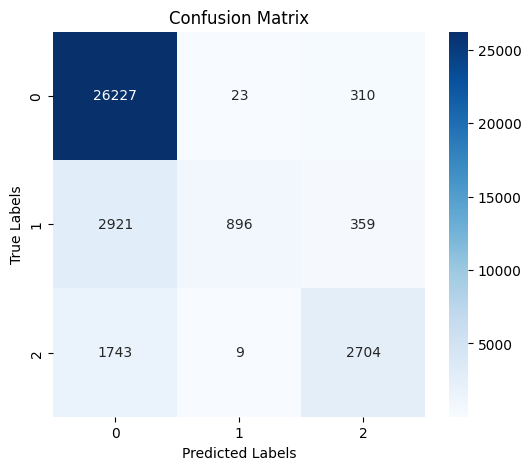

In [57]:
# Assuming y_test are true labels, and y_pred are predicted labels from your model
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

print("================ CLASSIFICATION REPORT ================")
print(pd.DataFrame(report).transpose())
print("================ CONFUSION MATRIC ================")

# Optional: Plot confusion matrix heatmap for better visualization
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


/opt/anaconda3/envs/projects/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:38:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


================ CLASSIFICATION REPORT ================
              precision    recall  f1-score       support
0              0.819890  0.985505  0.895101  26560.000000
1              0.842254  0.071600  0.131980   4176.000000
2              0.737981  0.482271  0.583333   4456.000000
accuracy       0.813338  0.813338  0.813338      0.813338
macro avg      0.800042  0.513125  0.536805  35192.000000
weighted avg   0.812173  0.813338  0.765071  35192.000000
================ CONFUSION MATRIC ================


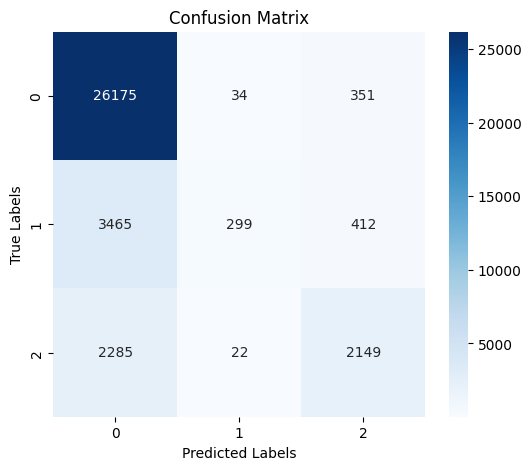

In [59]:
# Assuming y_test are true labels, and y_pred are predicted labels from your model
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)


print("================ CLASSIFICATION REPORT ================")
print(pd.DataFrame(report).transpose())
print("================ CONFUSION MATRIC ================")

# Optional: Plot confusion matrix heatmap for better visualization
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


##### Tuning the xgboost model

/opt/anaconda3/envs/projects/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:42:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


================ CLASSIFICATION REPORT ================
              precision    recall  f1-score      support
0              0.869156  0.747553  0.803781  26560.00000
1              0.230139  0.356561  0.279729   4176.00000
2              0.496257  0.654623  0.564544   4456.00000
accuracy       0.689390  0.689390  0.689390      0.68939
macro avg      0.531851  0.586246  0.549352  35192.00000
weighted avg   0.746112  0.689390  0.711303  35192.00000
================ CONFUSION MATRIC ================


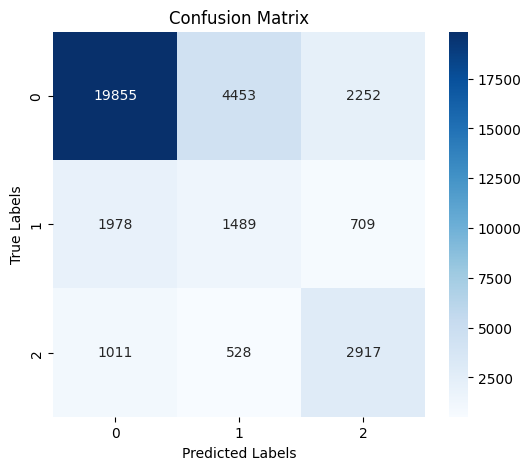

In [62]:
# based ont eh above confusion matrix, it is evident that xgboost is a better model. Hence I would like to fine tune that
# this is clearly better than the xgb model without scale pos weight. 
weights = compute_sample_weight('balanced', y_train)
xgb.fit(X_train, y_train, sample_weight=weights)
y_pred = xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)


print("================ CLASSIFICATION REPORT ================")
print(pd.DataFrame(report).transpose())
print("================ CONFUSION MATRIC ================")

# Optional: Plot confusion matrix heatmap for better visualization
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [65]:
# Compute sample weights to handle imbalance (optional)
sample_weights = compute_sample_weight('balanced', y_train)

xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_train)),
    eval_metric='mlogloss',
    random_state=42
)

# Define hyperparameter grid
param_grid = {
    'n_estimators':    [100, 200, 300],
    'max_depth':       [3, 4],
    'learning_rate':   [0.01, 0.05, 0.1],
    'subsample':       [0.8, 1],
    'colsample_bytree':[0.8, 1],
    'gamma':           [0, 0.1, 0.3],
    'reg_alpha':       [0, 0.01, 0.1],
    'reg_lambda':      [1, 2, 5],
    'min_child_weight':[1, 3, 5]
}

scorer = make_scorer(f1_score, average='macro')

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=scorer,
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Pass sample weights in fit
grid_search.fit(X_train, y_train, sample_weight=sample_weights)

print("Best parameters:", grid_search.best_params_)
print("Best macro F1 score:", grid_search.best_score_)


Fitting 3 folds for each of 8748 candidates, totalling 26244 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=1; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=1; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=1; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_chi

================ CLASSIFICATION REPORT ================
              precision    recall  f1-score       support
0              0.871219  0.759036  0.811268  26560.000000
1              0.245711  0.363506  0.293220   4176.000000
2              0.501702  0.661355  0.570571   4456.000000
accuracy       0.699733  0.699733  0.699733      0.699733
macro avg      0.539544  0.594632  0.558353  35192.000000
weighted avg   0.750206  0.699733  0.719317  35192.000000
================ CONFUSION MATRIX ================


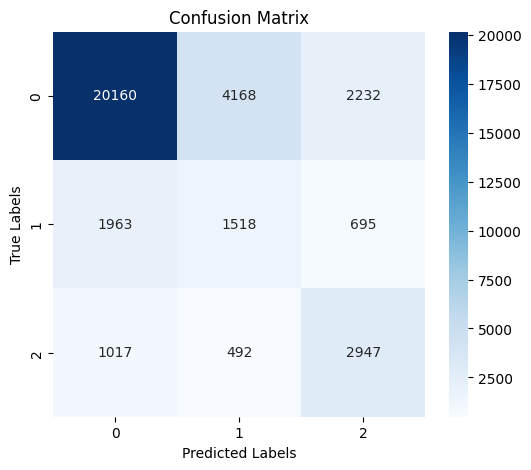

In [ ]:
# Best params from GridSearchCV
best_params = {
    'colsample_bytree': 0.8,
    'gamma': 0,
    'learning_rate': 0.2, 
    'max_depth': 5,
    'min_child_weight': 1,
    'n_estimators': 300,
    'reg_alpha': 0.1,
    'reg_lambda': 2,
    'subsample': 1,
    'objective': 'multi:softprob',
    'num_class': len(pd.unique(y_train)),
    'eval_metric': 'mlogloss',
    'random_state': 42
}

# Initialize and fit model
xgb_tuned = XGBClassifier(**best_params)
weights = compute_sample_weight('balanced', y_train)
xgb_tuned.fit(X_train, y_train, sample_weight=weights)

# Predict and evaluate
y_pred = xgb_tuned.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

print("================ CLASSIFICATION REPORT ================")
print(pd.DataFrame(report).transpose())
print("================ CONFUSION MATRIX ================")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [86]:
def objective(trial):
    param = {
        'objective': 'multi:softprob',
        'num_class': len(set(y_train)),
        'eval_metric': 'mlogloss',
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 2.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        # 'scale_pos_weight' is not set (ignored for multi-class)
    }
    # Use class-balanced sample weights:
    sample_weights = compute_sample_weight("balanced", y_train)
    model = XGBClassifier(**param)
    model.fit(X_train, y_train, sample_weight=sample_weights, verbose=False)
    preds = model.predict(X_test)
    macro_f1 = f1_score(y_test, preds, average='macro')
    return macro_f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150)  # Increase n_trials for more thorough search

print("Best macro F1 score:", study.best_value)
print("Best hyperparameters:", study.best_params)

[I 2025-08-05 20:02:55,770] A new study created in memory with name: no-name-5970cd82-3ac1-4598-890d-23be994fd6b8
[I 2025-08-05 20:02:56,667] Trial 0 finished with value: 0.4775672540613976 and parameters: {'max_depth': 2, 'learning_rate': 0.07890367068354259, 'n_estimators': 217, 'subsample': 0.7831026222462799, 'colsample_bytree': 0.6417943436833543, 'gamma': 0.280545212458575, 'reg_alpha': 0.16119377976863403, 'reg_lambda': 3.3991911404605255, 'min_child_weight': 1}. Best is trial 0 with value: 0.4775672540613976.
[I 2025-08-05 20:02:57,508] Trial 1 finished with value: 0.4792249258620151 and parameters: {'max_depth': 2, 'learning_rate': 0.1033796325210701, 'n_estimators': 201, 'subsample': 0.965444819961732, 'colsample_bytree': 0.612295641552008, 'gamma': 1.839513485572469, 'reg_alpha': 0.03743549317456074, 'reg_lambda': 3.221627771374814, 'min_child_weight': 6}. Best is trial 1 with value: 0.4792249258620151.
[I 2025-08-05 20:02:58,942] Trial 2 finished with value: 0.5164300157674

Best macro F1 score: 0.5927635405975014
Best hyperparameters: {'max_depth': 5, 'learning_rate': 0.29140956660727946, 'n_estimators': 399, 'subsample': 0.9134059768432797, 'colsample_bytree': 0.9980383086546663, 'gamma': 0.0017105687199672742, 'reg_alpha': 0.3143587517943764, 'reg_lambda': 1.6851739688263998, 'min_child_weight': 1}


price  freight_value  product_description_lenght  product_weight_g  \
16861   78.00          15.30                       319.0             250.0   
13148   27.00          24.84                       600.0             400.0   
84356   34.30          15.10                      1382.0             200.0   
1334    49.90          17.26                       366.0            1650.0   
73324  299.00          19.97                      1479.0             150.0   
...       ...            ...                         ...               ...   
55336   79.00          17.80                       241.0            6100.0   
17015   57.49          11.15                       890.0             950.0   
9723    41.50          11.85                       859.0             150.0   
55244   56.99          20.85                      1003.0             400.0   
2245    53.99          14.13                       340.0             300.0   

       product_length_cm  seller_zip_code_prefix  customer_zip_code_prefix  \
16861               16.0                    5849                     96010   
13148               50.0                   96080                     76824   
84356               16.0                   13483                     79150   
1334                30.0                   15025                      5735   
73324               23.0                   87045                     98280   
...                  ...                     ...                       ...   
55336               60.0                   13232                     29154   
17015               29.0                    2274                      2652   
9723                16.0                   14092                      5665   
55244               18.0                    9015                     57055   
2245                48.0                   31140                     23013   

       customer_city  payment_value  approval_delay  delivery_carrier_time  \
16861           2779          93.30        1.016944              79.869167   
13148           2977         103.68        0.199444              22.790556   
84356           2203          49.40       39.201667              88.855833   
1334            3586         134.32        0.435278              38.024722   
73324           2649         637.94        0.239444              27.587500   
...              ...            ...             ...                    ...   
55336            827          96.80      143.497222             154.768056   
17015           3586          68.64       24.677222              80.563611   
9723            3586          53.35        0.401944              40.011667   
55244           2144          77.84        0.128333              88.523333   
2245            3146          68.12        0.146389              37.590556   

       delivery_customer_time  total_delivery_time  estimated_delivery_gap  \
16861              196.541389           277.427500              623.594444   
13148              249.096389           272.086389              898.154722   
84356              526.743889           654.801389              683.908611   
1334               149.855833           188.315833              721.260000   
73324              194.829167           222.656111              925.060278   
...                       ...                  ...                     ...   
55336              814.746389          1113.011667              589.191111   
17015               28.501667           133.742500              286.090833   
9723               161.930000           202.343611              542.258333   
55244              695.349722           784.001389              774.708889   
2245              1053.602222          1091.339167              707.556667   

       delivery_delay  order_hour  review_response_time  \
16861     -346.166944           0             74.761667   
13148     -626.068333          13             69.036111   
84356      -29.107222          12             71.182222   
1334      -532.944167   

In [ ]:
# 50 trial best parameters
# {'max_depth': 5, 
#  'learning_rate': 0.27601884888752576, 
#  'n_estimators': 382, 
#  'subsample': 0.9324235891594851, 
#  'colsample_bytree': 0.8205790445717083, 
#  'gamma': 0.5611541381491353, 
#  'reg_alpha': 0.481895222953481, 
#  'reg_lambda': 2.1877326902885335, 
#  'min_child_weight': 2}

================ CLASSIFICATION REPORT ================
              precision    recall  f1-score       support
0              0.872310  0.795030  0.831879  26560.000000
1              0.274248  0.369013  0.314650   4176.000000
2              0.549571  0.661804  0.600489   4456.000000
accuracy       0.727609  0.727609  0.727609      0.727609
macro avg      0.565376  0.608616  0.582339  35192.000000
weighted avg   0.760477  0.727609  0.741204  35192.000000
================ CONFUSION MATRIX ================


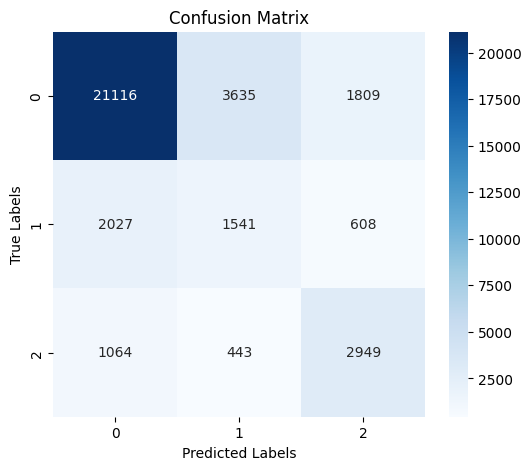

In [89]:
# Best params from Optuna - 50 trials
best_params = {
    'max_depth': 5, 
    'learning_rate': 0.27601884888752576, 
    'n_estimators': 382, 
    'subsample': 0.9324235891594851, 
    'colsample_bytree': 0.8205790445717083, 
    'gamma': 0.5611541381491353, 
    'reg_alpha': 0.481895222953481, 
    'reg_lambda': 2.1877326902885335, 
    'min_child_weight': 2,
    'objective': 'multi:softprob',
    'num_class': len(pd.unique(y_train)),
    'eval_metric': 'mlogloss',
    'random_state': 42
}

# Initialize and fit model
xgb_tuned = XGBClassifier(**best_params)
weights = compute_sample_weight('balanced', y_train)
xgb_tuned.fit(X_train, y_train, sample_weight=weights)

# Predict and evaluate
y_pred = xgb_tuned.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

print("================ CLASSIFICATION REPORT ================")
print(pd.DataFrame(report).transpose())
print("================ CONFUSION MATRIX ================")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [87]:
#Best hyperparameters of 150 trials: 
# {'max_depth': 5, 
# 'learning_rate': 0.29140956660727946, 
# 'n_estimators': 399, 
# 'subsample': 0.9134059768432797, 
# 'colsample_bytree': 0.9980383086546663, 
# 'gamma': 0.0017105687199672742, 
# 'reg_alpha': 0.3143587517943764, 
# 'reg_lambda': 1.6851739688263998, 
# 'min_child_weight': 1}


================ CLASSIFICATION REPORT ================
              precision    recall  f1-score       support
0              0.871614  0.810542  0.839970  26560.000000
1              0.287023  0.367577  0.322344   4176.000000
2              0.574733  0.663600  0.615978   4456.000000
accuracy       0.739373  0.739373  0.739373      0.739373
macro avg      0.577790  0.613906  0.592764  35192.000000
weighted avg   0.764654  0.739373  0.750185  35192.000000
================ CONFUSION MATRIX ================


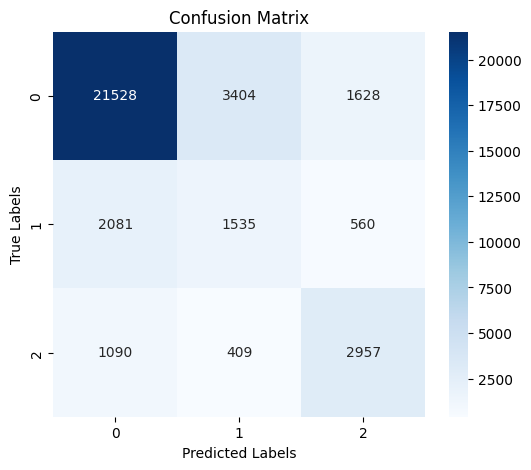

In [17]:
# Best params from optuna - 150 trial
best_params = {
    'max_depth': 5, 
    'learning_rate': 0.29140956660727946, 
    'n_estimators': 399, 
    'subsample': 0.9134059768432797, 
    'colsample_bytree': 0.9980383086546663, 
    'gamma': 0.0017105687199672742, 
    'reg_alpha': 0.3143587517943764, 
    'reg_lambda': 1.6851739688263998, 
    'min_child_weight': 1,
    'objective': 'multi:softprob',
    'num_class': len(pd.unique(y_train)),
    'eval_metric': 'mlogloss',
    'random_state': 42
}

# Initialize and fit model
xgb_tuned = XGBClassifier(**best_params)
weights = compute_sample_weight('balanced', y_train)
xgb_tuned.fit(X_train, y_train, sample_weight=weights)

# Predict and evaluate
y_pred = xgb_tuned.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

print("================ CLASSIFICATION REPORT ================")
print(pd.DataFrame(report).transpose())
print("================ CONFUSION MATRIX ================")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# as the model will not improve in performace due to class imbaalnce trying out few other techniques. 

##### Manual Class Weighting with sample_weight

================ CLASSIFICATION REPORT ================
              precision    recall  f1-score       support
0              0.884154  0.577297  0.698510  26560.000000
1              0.191723  0.519157  0.280031   4176.000000
2              0.465454  0.683348  0.553737   4456.000000
accuracy       0.583826  0.583826  0.583826      0.583826
macro avg      0.513777  0.593267  0.510759  35192.000000
weighted avg   0.748972  0.583826  0.630521  35192.000000
================ CONFUSION MATRIX ================


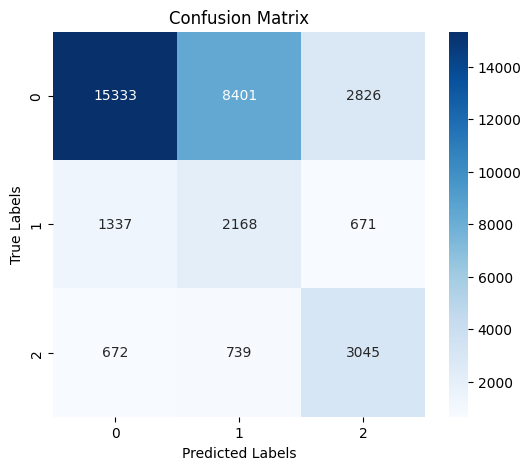

In [94]:
from sklearn.utils.class_weight import compute_sample_weight

# Original balanced weights
weights = compute_sample_weight('balanced', y_train)

# Amplify minority classes weights manually
weights = np.array(weights)
weights[y_train == 1] *= 2.0 # Adjust factor as needed
weights[y_train == 2] *= 2.0

best_params = {
    'max_depth': 5, 
    'learning_rate': 0.29140956660727946, 
    'n_estimators': 399, 
    'subsample': 0.9134059768432797, 
    'colsample_bytree': 0.9980383086546663, 
    'gamma': 0.0017105687199672742, 
    'reg_alpha': 0.3143587517943764, 
    'reg_lambda': 1.6851739688263998, 
    'min_child_weight': 1,
    'objective': 'multi:softprob',
    'num_class': len(pd.unique(y_train)),
    'eval_metric': 'mlogloss',
    'random_state': 42
}

# Train model with custom weights
xgb = XGBClassifier(**best_params)

xgb.fit(X_train, y_train, sample_weight=weights)

# Predict and evaluate
y_pred = xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

print("================ CLASSIFICATION REPORT ================")
print(pd.DataFrame(report).transpose())
print("================ CONFUSION MATRIX ================")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

##### Two-Stage (Cascade) Modeling

In [ ]:
# Stage 1: Train model to classify class 0 vs (class 1 or 2)
y_train_stage1 = (y_train != 0).astype(int)  

xgb_stage1 = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
xgb_stage1.fit(X_train, y_train_stage1)

# Predict stage 1 on test data
stage1_pred = xgb_stage1.predict(X_test)

# Stage 2: For instances predicted as Not 0, classify between class 1 and 2
X_train_stage2 = X_train[y_train != 0]
y_train_stage2 = y_train[y_train != 0] - 1  # Remap classes: 1->0, 2->1

xgb_stage2 = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
xgb_stage2.fit(X_train_stage2, y_train_stage2)

# For test samples with stage1_pred==1, predict class 1 or 2
X_test_stage2 = X_test[stage1_pred == 1]
stage2_pred = xgb_stage2.predict(X_test_stage2)

# Combine final predictions
# Assuming stage1_pred, stage2_pred, X_test, y_test are defined as in your code

final_pred = np.zeros_like(stage1_pred)
idx_stage2 = np.where(stage1_pred == 1)[0]
final_pred[idx_stage2] = stage2_pred + 1  # map back classes

from sklearn.metrics import f1_score
print("Two-stage Macro F1:", f1_score(y_test, final_pred, average='macro'))

Two-stage Macro F1: 0.5609098232671178


In [97]:
# Stage 1 — binary: class 0 vs class 1/2
y_train_stage1 = (y_train != 0).astype(int)
y_test_stage1 = (y_test != 0).astype(int)

# Stage 2 — binary: class 1 vs class 2 
X_train_stage2 = X_train[y_train != 0]
y_train_stage2 = y_train[y_train != 0] - 1   # remap: 1→0, 2→1
X_test_stage2 = X_test[y_test != 0]
y_test_stage2 = y_test[y_test != 0] - 1

In [99]:
def objective_stage1(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 2.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 25),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 25),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }
    sample_weights = compute_sample_weight('balanced', y_train_stage1)
    model = XGBClassifier(**param)
    model.fit(X_train, y_train_stage1, sample_weight=sample_weights, verbose=False)
    preds = model.predict(X_test)
    return f1_score(y_test_stage1, preds)

study_stage1 = optuna.create_study(direction='maximize')
study_stage1.optimize(objective_stage1, n_trials=50)
print("Best params for stage 1:", study_stage1.best_params)


[I 2025-08-05 20:49:04,214] A new study created in memory with name: no-name-062e8387-1ec8-4bcb-8ed5-4113cb7e3a83
[I 2025-08-05 20:49:05,424] Trial 0 finished with value: 0.5320731329408119 and parameters: {'max_depth': 4, 'learning_rate': 0.03980594373591911, 'n_estimators': 559, 'subsample': 0.7303228886065952, 'colsample_bytree': 0.8436198240928667, 'gamma': 0.5442877816694112, 'reg_alpha': 2.488239935330541, 'reg_lambda': 11.984803564779444, 'min_child_weight': 2}. Best is trial 0 with value: 0.5320731329408119.
[I 2025-08-05 20:49:06,614] Trial 1 finished with value: 0.5574603174603174 and parameters: {'max_depth': 4, 'learning_rate': 0.2289943866651211, 'n_estimators': 569, 'subsample': 0.7849730692483655, 'colsample_bytree': 0.6772029950417872, 'gamma': 0.1782155424476244, 'reg_alpha': 8.68771613099275, 'reg_lambda': 8.069780122678825, 'min_child_weight': 1}. Best is trial 1 with value: 0.5574603174603174.
[I 2025-08-05 20:49:07,816] Trial 2 finished with value: 0.55509421909932

Best params for stage 1: {'max_depth': 5, 'learning_rate': 0.18617665315547585, 'n_estimators': 405, 'subsample': 0.9093115910642681, 'colsample_bytree': 0.74531789909341, 'gamma': 1.1738224516794624, 'reg_alpha': 1.610639898726335, 'reg_lambda': 10.45190333407599, 'min_child_weight': 2}


In [100]:
def objective_stage2(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'random_state': 42,
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 2.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 25),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 25),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }
    sample_weights = compute_sample_weight('balanced', y_train_stage2)
    model = XGBClassifier(**param)
    model.fit(X_train_stage2, y_train_stage2, sample_weight=sample_weights, verbose=False)
    preds = model.predict(X_test_stage2)
    return f1_score(y_test_stage2, preds)

study_stage2 = optuna.create_study(direction='maximize')
study_stage2.optimize(objective_stage2, n_trials=50)
print("Best params for stage 2:", study_stage2.best_params)


[I 2025-08-05 20:49:55,417] A new study created in memory with name: no-name-8313933c-c488-4e86-8dc6-ca98758650df
[I 2025-08-05 20:49:55,983] Trial 0 finished with value: 0.731203007518797 and parameters: {'max_depth': 5, 'learning_rate': 0.17269567569548147, 'n_estimators': 364, 'subsample': 0.7657344662347586, 'colsample_bytree': 0.9369075044976073, 'gamma': 1.633328318996235, 'reg_alpha': 1.0133258094866955, 'reg_lambda': 1.2302774105531276, 'min_child_weight': 9}. Best is trial 0 with value: 0.731203007518797.
[I 2025-08-05 20:49:56,380] Trial 1 finished with value: 0.7004129793510324 and parameters: {'max_depth': 3, 'learning_rate': 0.1893550214124928, 'n_estimators': 439, 'subsample': 0.700931816230211, 'colsample_bytree': 0.9529554006660304, 'gamma': 0.8328339750653324, 'reg_alpha': 3.8649735898949213, 'reg_lambda': 21.778963973500222, 'min_child_weight': 4}. Best is trial 0 with value: 0.731203007518797.
[I 2025-08-05 20:49:56,812] Trial 2 finished with value: 0.691012568176428

Best params for stage 2: {'max_depth': 5, 'learning_rate': 0.2129688466766656, 'n_estimators': 596, 'subsample': 0.814531623209642, 'colsample_bytree': 0.6129959726178625, 'gamma': 0.2085552271633329, 'reg_alpha': 8.218782799478513, 'reg_lambda': 8.876341174111758, 'min_child_weight': 1}


================ CLASSIFICATION REPORT ================
              precision    recall  f1-score       support
0              0.864369  0.833810  0.848815  26560.000000
1              0.309250  0.296216  0.302593   4176.000000
2              0.520014  0.650135  0.577840   4456.000000
accuracy       0.746761  0.746761  0.746761      0.746761
macro avg      0.564544  0.593387  0.576416  35192.000000
weighted avg   0.754895  0.746761  0.749687  35192.000000
================ CONFUSION MATRIX ================


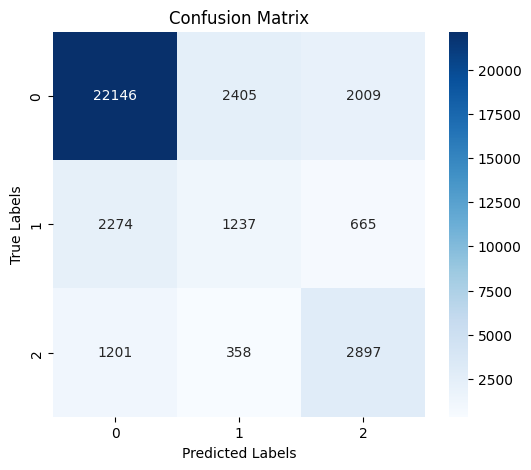

Macro F1 score: 0.5764158300373826


In [101]:
# Replace with your best params from Optuna
best_params_stage1 = {'max_depth': 5, 'learning_rate': 0.18617665315547585, 'n_estimators': 405, 'subsample': 0.9093115910642681, 'colsample_bytree': 0.74531789909341, 'gamma': 1.1738224516794624, 'reg_alpha': 1.610639898726335, 'reg_lambda': 10.45190333407599, 'min_child_weight': 2}
best_params_stage2 = {'max_depth': 5, 'learning_rate': 0.2129688466766656, 'n_estimators': 596, 'subsample': 0.814531623209642, 'colsample_bytree': 0.6129959726178625, 'gamma': 0.2085552271633329, 'reg_alpha': 8.218782799478513, 'reg_lambda': 8.876341174111758, 'min_child_weight': 1}

# Train stage 1
model_stage1 = XGBClassifier(**best_params_stage1)
weights_stage1 = compute_sample_weight('balanced', y_train_stage1)
model_stage1.fit(X_train, y_train_stage1, sample_weight=weights_stage1, verbose=False)
stage1_pred = model_stage1.predict(X_test)

# Train stage 2
model_stage2 = XGBClassifier(**best_params_stage2)
weights_stage2 = compute_sample_weight('balanced', y_train_stage2)
model_stage2.fit(X_train_stage2, y_train_stage2, sample_weight=weights_stage2, verbose=False)

# Predict for stage 2: only for test samples predicted not 0 in stage 1
X_test_stage2_pred = X_test[stage1_pred == 1]
stage2_pred = model_stage2.predict(X_test_stage2_pred)

# Combine predictions into final_pred over the whole test set
final_pred = np.zeros_like(stage1_pred)
idx_stage2 = np.where(stage1_pred == 1)[0]
final_pred[idx_stage2] = stage2_pred + 1  # Remap: class 0→1, 1→2

# Evaluate and print
cm = confusion_matrix(y_test, final_pred)
report = classification_report(y_test, final_pred, output_dict=True)

print("================ CLASSIFICATION REPORT ================")
print(pd.DataFrame(report).transpose())
print("================ CONFUSION MATRIX ================")
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("Macro F1 score:", f1_score(y_test, final_pred, average='macro'))


##### Probability threshold tweaking

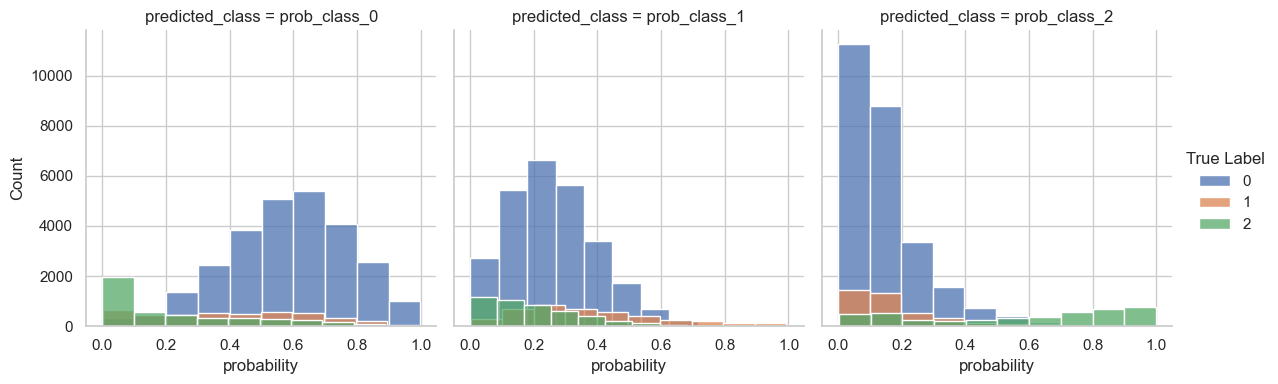

In [109]:
probs = xgb_tuned.predict_proba(X_test)
result_df = pd.DataFrame(probs, columns=[f'prob_class_{i}' for i in range(probs.shape[1])])
result_df['true_label'] = y_test.reset_index(drop=True)

# Melt the DataFrame for seaborn compatibility
result_melted = result_df.melt(id_vars='true_label', 
                               var_name='predicted_class', 
                               value_name='probability')

# Plot histograms for each predicted class probability, colored by true label
sns.set(style='whitegrid')
g = sns.FacetGrid(result_melted, col='predicted_class', hue='true_label', 
                  sharex=True, sharey=True, height=4)
g.map(sns.histplot, 'probability', bins=10, multiple='stack')
g.add_legend(title='True Label')
plt.show()


In [131]:
from tqdm import tqdm

def find_thresholds_record(probs, y_test):
    records = []
    thresholds = np.arange(0, 1.05, 0.05)

    for t1 in tqdm(thresholds, desc='Threshold 1'):
        for t2 in tqdm(thresholds, desc='Threshold 2', leave=False):
            adjusted_pred = []
            for p in probs:
                if p[1] > t1:
                    adjusted_pred.append(1)
                elif p[2] > t2:
                    adjusted_pred.append(2)
                else:
                    adjusted_pred.append(0)
            score = f1_score(y_test, adjusted_pred, average='macro')
            records.append({'threshold_1': t1, 'threshold_2': t2, 'macro_f1': score})

    df_results = pd.DataFrame(records)
    return df_results


probs = xgb_tuned.predict_proba(X_test)
df_thresholds = find_thresholds_record(probs, y_test)


Threshold 1: 100%|██████████| 21/21 [00:07<00:00,  2.86it/s]


In [132]:
df_thresholds

threshold_1  threshold_2  macro_f1
0            0.0         0.00  0.070717
1            0.0         0.05  0.070717
2            0.0         0.10  0.070717
3            0.0         0.15  0.070717
4            0.0         0.20  0.070717
..           ...          ...       ...
436          1.0         0.80  0.447774
437          1.0         0.85  0.419265
438          1.0         0.90  0.383943
439          1.0         0.95  0.339337
440          1.0         1.00  0.286738

[441 rows x 3 columns]

In [ ]:
# Get predicted probabilities for each class
probs = xgb_tuned.predict_proba(X_test)

# Default prediction: class with max probability
default_pred = np.argmax(probs, axis=1)
print(default_pred)

# Adjust thresholds for classes 1 and 2
threshold_1 = 0.5#0.5 
threshold_2 = 0.5#0.4

adjusted_pred = []
for p in probs:
    if p[1] > threshold_1:
        adjusted_pred.append(1)
    elif p[2] > threshold_2:
        adjusted_pred.append(2)
    else:
        # Default to class 0 if thresholds not met
        adjusted_pred.append(0)

print("Threshold moving Macro F1:", f1_score(y_test, adjusted_pred, average='macro'))


[0 0 1 ... 0 0 0]
Threshold moving Macro F1: 0.6109532236809544


In [57]:
X_test

price  freight_value  product_description_lenght  product_weight_g  \
105561   34.90          16.79                       349.0             500.0   
47410   599.00          24.68                      1811.0            5250.0   
60213   118.58          16.59                       124.0             800.0   
114719   49.95          11.85                       213.0             400.0   
69559     8.49           7.87                      3400.0             250.0   
...        ...            ...                         ...               ...   
16932    59.50          22.35                       763.0             150.0   
10607    12.99           7.78                       267.0             150.0   
64539   159.90          19.29                      2596.0            7474.0   
65012    35.00          16.11                       311.0            1013.0   
30961    55.00           7.78                       335.0             250.0   

        product_length_cm  seller_zip_code_prefix  customer_zip_code_prefix  \
105561               16.0                   70645                     14402   
47410                56.0                   60348                     56800   
60213                95.0                   14940                     88063   
114719               25.0                   14940                      1447   
69559                25.0                   11701                      9912   
...                   ...                     ...                       ...   
16932                20.0                   14407                     48990   
10607                20.0                    4265                      5716   
64539                54.0                    2066                      4877   
65012                30.0                   88308                     12721   
30961                16.0                    5849                      8738   

        customer_city  payment_value  approval_delay  delivery_carrier_time  \
105561           1379          10.74        0.248056              47.218889   
47410              28         623.68       40.544167              28.026389   
60213            1355          55.20       24.953611              43.411111   
114719           3586          61.80        0.203889              23.104722   
69559            1170          16.36       14.373889               3.061667   
...               ...            ...             ...                    ...   
16932             170          81.85        0.214167              70.796111   
10607            3586          20.77        0.285000              20.517500   
64539            3586         179.19        0.163889              21.119444   
65012            1123         102.22        1.958889              41.505833   
30961            2335          62.78        1.074722              69.768333   

        delivery_customer_time  total_delivery_time  estimated_delivery_gap  \
105561              241.344444           288.811389              725.991111   
47410               269.272222           337.842778              750.762778   
60213               192.977778           261.342500              582.862778   
114719               52.946667            76.255278              489.471667   
69559                56.430833            73.866389               98.785556   
...                        ...                  ...                     ...   
16932               219.533611           290.543889              562.460278   
10607                20.955833            41.758333              287.216944   
64539                75.931389            97.214722              172.066667   
65012               169.973611           213.438333              507.036944   
30961                28.737778            99.580833              291.630278   

        delivery_delay  order_hour  review_response_time  \
105561     -437.179722          18             71.577500   
47410      -412.920000          17             22.442500   
60213      -321.520278          1

================ CLASSIFICATION REPORT ================
              precision    recall  f1-score       support
0              0.851809  0.909601  0.879757  26560.000000
1              0.380457  0.262931  0.310960   4176.000000
2              0.683824  0.605251  0.642143   4456.000000
accuracy       0.794328  0.794328  0.794328      0.794328
macro avg      0.638697  0.592594  0.610953  35192.000000
weighted avg   0.774606  0.794328  0.782175  35192.000000
================ CONFUSION MATRIX ================


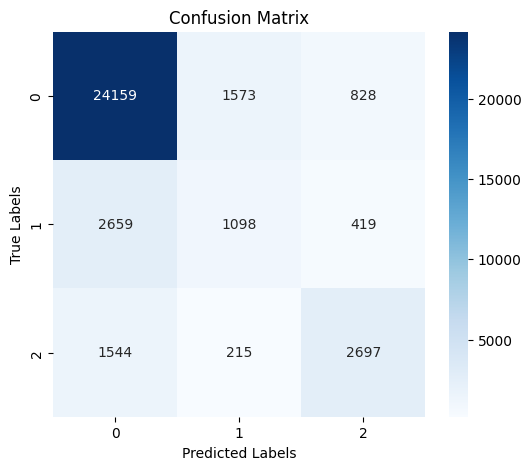

In [ ]:
cm = confusion_matrix(y_test, adjusted_pred)
report = classification_report(y_test, adjusted_pred, output_dict=True)

print("================ CLASSIFICATION REPORT ================")
print(pd.DataFrame(report).transpose())
print("================ CONFUSION MATRIX ================")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

##### geting data for power bi

In [60]:
def review_target(review_score):
    if review_score > 3:
        return 1 # good
    elif review_score == 1:
        return 3 # bad
    else:
        return 2 #neutral
    
df['review_target'] = df['review_score'].apply(review_target)

In [67]:
X_download

order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3       53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4       47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
...                                  ...                               ...   
117324  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
117325  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
117326  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
117327  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
117328  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

       order_purchase_timestamp   order_approved_at  \
0           2017-10-02 10:56:33 2017-10-02 11:07:15   
1           2017-10-02 10:56:33 2017-10-02 11:07:15   
2           2017-10-02 10:56:33 2017-10-02 11:07:15   
3           2018-07-24 20:41:37 2018-07-26 03:24:27   
4           2018-08-08 08:38:49 2018-08-08 08:55:23   
...                         ...                 ...   
117324      2018-02-06 12:58:58 2018-02-06 13:10:37   
117325      2017-08-27 14:46:43 2017-08-27 15:04:16   
117326      2018-01-08 21:28:27 2018-01-08 21:36:21   
117327      2018-01-08 21:28:27 2018-01-08 21:36:21   
117328      2018-03-08 20:57:30 2018-03-09 11:20:28   

       order_delivered_carrier_date order_delivered_customer_date  \
0               2017-10-04 19:55:00           2017-10-10 21:25:13   
1               2017-10-04 19:55:00           2017-10-10 21:25:13   
2               2017-10-04 19:55:00           2017-10-10 21:25:13   
3               2018-07-26 14:31:00           2018-08-07 15:27:45   
4               2018-08-08 13:50:00           2018-08-17 18:06:29   
...                             ...                           ...   
117324          2018-02-07 23:22:42           2018-02-28 17:37:56   
117325          2017-08-28 20:52:26           2017-09-21 11:24:17   
117326          2018-01-12 15:35:03           2018-01-25 23:32:54   
117327          2018-01-12 15:35:03           2018-01-25 23:32:54   
117328          2018-03-09 22:11:59           2018-03-16 13:08:30   

       order_estimated_delivery_date  order_item_id  \
0                         2017-10-18              1   
1                         2017-10-18              1   
2                         2017-10-18              1   
3                         2018-08-13              1   
4                         2018-09-04              1   
...                              ...            ...   
117324                    2018-03-02              1   
117325                    2017-09-27              1   
117326                    2018-02-15              1   
117327                    2018-02-15              2   
117328                    2018-04-03              1   

                              product_id                         seller_id  \
0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
2       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
3       595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
4       aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   
...                                  ...                               ...   
117324  f1d4ce8c6dd66c47bbaa8c6781c2a923  1f9ab4708f3056ede07124aad39a2554   
117325  b80910977a37536adeddd63663f916ad  d50d79cb34e38265a8649c383dcffd48   
117326  d1c427060a0f73f6b889a5c7c61f2ac4  a1043bafd471dff536d0c462352beb48   
117327  d1c427060a0f73f6b889a5c7c61f2ac4  a1043bafd471dff536d0c462352beb48   
117328  006619bbed68b000c8ba3f8725d5409e  ececbfcff9804a2d6b40f589df8eef2b   

       

In [66]:
y_download

0         0
1         0
2         0
3         0
4         0
         ..
117324    0
117325    0
117326    1
117327    1
117328    0
Name: review_target, Length: 117306, dtype: int64

In [64]:
df = df.dropna()
X_download = df.copy()
y_download = df['review_target'] 
y_download = df['review_target'].replace({1: 0, 2: 1, 3: 2}) 

# Split data
X_download_train, X_download_test, y_download_train, y_download_test = train_test_split(X_download, y_download, test_size=0.3, random_state=42, stratify=y_download)

In [58]:
df

order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3       53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4       47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
...                                  ...                               ...   
117324  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
117325  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
117326  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
117327  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
117328  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

       order_purchase_timestamp   order_approved_at  \
0           2017-10-02 10:56:33 2017-10-02 11:07:15   
1           2017-10-02 10:56:33 2017-10-02 11:07:15   
2           2017-10-02 10:56:33 2017-10-02 11:07:15   
3           2018-07-24 20:41:37 2018-07-26 03:24:27   
4           2018-08-08 08:38:49 2018-08-08 08:55:23   
...                         ...                 ...   
117324      2018-02-06 12:58:58 2018-02-06 13:10:37   
117325      2017-08-27 14:46:43 2017-08-27 15:04:16   
117326      2018-01-08 21:28:27 2018-01-08 21:36:21   
117327      2018-01-08 21:28:27 2018-01-08 21:36:21   
117328      2018-03-08 20:57:30 2018-03-09 11:20:28   

       order_delivered_carrier_date order_delivered_customer_date  \
0               2017-10-04 19:55:00           2017-10-10 21:25:13   
1               2017-10-04 19:55:00           2017-10-10 21:25:13   
2               2017-10-04 19:55:00           2017-10-10 21:25:13   
3               2018-07-26 14:31:00           2018-08-07 15:27:45   
4               2018-08-08 13:50:00           2018-08-17 18:06:29   
...                             ...                           ...   
117324          2018-02-07 23:22:42           2018-02-28 17:37:56   
117325          2017-08-28 20:52:26           2017-09-21 11:24:17   
117326          2018-01-12 15:35:03           2018-01-25 23:32:54   
117327          2018-01-12 15:35:03           2018-01-25 23:32:54   
117328          2018-03-09 22:11:59           2018-03-16 13:08:30   

       order_estimated_delivery_date  order_item_id  \
0                         2017-10-18              1   
1                         2017-10-18              1   
2                         2017-10-18              1   
3                         2018-08-13              1   
4                         2018-09-04              1   
...                              ...            ...   
117324                    2018-03-02              1   
117325                    2017-09-27              1   
117326                    2018-02-15              1   
117327                    2018-02-15              2   
117328                    2018-04-03              1   

                              product_id                         seller_id  \
0       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
2       87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
3       595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
4       aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   
...                                  ...                               ...   
117324  f1d4ce8c6dd66c47bbaa8c6781c2a923  1f9ab4708f3056ede07124aad39a2554   
117325  b80910977a37536adeddd63663f916ad  d50d79cb34e38265a8649c383dcffd48   
117326  d1c427060a0f73f6b889a5c7c61f2ac4  a1043bafd471dff536d0c462352beb48   
117327  d1c427060a0f73f6b889a5c7c61f2ac4  a1043bafd471dff536d0c462352beb48   
117328  006619bbed68b000c8ba3f8725d5409e  ececbfcff9804a2d6b40f589df8eef2b   

       

In [69]:
X_download_test['perdicted_class'] = adjusted_pred
X_download_test['actual_class'] = y_download_test

In [74]:
X_download_test.to_parquet('test_dataset.parquet', index=False)

##### Downloading model

In [21]:
import pickle

In [ ]:
with open("model.pkl", "wb") as f:
    pickle.dump(xgb_tuned, f)

In [45]:
booster = xgb_tuned.get_booster()
booster.save_model("model.json")

In [52]:
print(df.iloc[0])

order_id                        e481f51cbdc54678b7cc49136f2d6af7
customer_id                     9ef432eb6251297304e76186b10a928d
order_purchase_timestamp                     2017-10-02 10:56:33
order_approved_at                            2017-10-02 11:07:15
order_delivered_carrier_date                 2017-10-04 19:55:00
                                              ...               
order_status_delivered                                         1
order_status_invoiced                                          0
order_status_processing                                        0
order_status_shipped                                           0
order_status_unavailable                                       0
Name: 0, Length: 145, dtype: object


In [55]:
df[['review_score', 'order_id', 'customer_id']]

review_score                          order_id  \
0                  4  e481f51cbdc54678b7cc49136f2d6af7   
1                  4  e481f51cbdc54678b7cc49136f2d6af7   
2                  4  e481f51cbdc54678b7cc49136f2d6af7   
3                  4  53cdb2fc8bc7dce0b6741e2150273451   
4                  5  47770eb9100c2d0c44946d9cf07ec65d   
...              ...                               ...   
117324             4  63943bddc261676b46f01ca7ac2f7bd8   
117325             5  83c1379a015df1e13d02aae0204711ab   
117326             2  11c177c8e97725db2631073c19f07b62   
117327             2  11c177c8e97725db2631073c19f07b62   
117328             5  66dea50a8b16d9b4dee7af250b4be1a5   

                             customer_id  
0       9ef432eb6251297304e76186b10a928d  
1       9ef432eb6251297304e76186b10a928d  
2       9ef432eb6251297304e76186b10a928d  
3       b0830fb4747a6c6d20dea0b8c802d7ef  
4       41ce2a54c0b03bf3443c3d931a367089  
...                                  ...  
117324  1fca14ff2861355f6e5f14306ff977a7  
117325  1aa71eb042121263aafbe80c1b562c9c  
117326  b331b74b18dc79bcdf6532d51e1637c1  
117327  b331b74b18dc79bcdf6532d51e1637c1  
117328  edb027a75a1449115f6b43211ae02a24  

[117329 rows x 3 columns]

# Inference for Customer Satisfaction Model

## Observations by Business-relevant Class:

#### Class 0 (“Good”/Satisfied)
- All models have very strong recall (lowest: 80%, highest: 91%).
- Precision and F1 are highest , so you are correctly identifying almost all your "good" customers.

#### Class 1 (“Neutral”/At-risk)
- All models struggle with class 1.
- Precision is the best.

#### Class 2 (“Bad”/Dissatisfied)
- Model 3 excels in precision for class 2 (0.68, highest across models). This means customers identified as "bad" are truly bad at a much higher rate—enabling more targeted, cost-effective outreach.
- Slight drop in recall for class 2 (0.61 vs. 0.66 in others), but this is a natural trade-off when increasing precision.

## Business stakeholder explanation and recommendation:

### Why Model 3 is best:

1. Highest Macro F1 and Accuracy:  
   Model 3 outperforms in overall accuracy (0.79) and macro F1 (0.61), demonstrating it’s the most balanced across all customer types.

2. Actionable “Bad” Customer Identification:  
   If your priority is to minimize wasted outreach and focus efforts where they will make the most difference (reducing bad reviews, churn, or costly customer service calls), Model 3’s jump in precision on class 2 (0.68) is extremely valuable, allowing your ops, care, or retention team to focus efforts where they matter.

3. Quality over Quantity for “At-risk”:  
   While Model 1 captures more at-risk users (higher recall), many of them are actually good, so your follow-up campaigns could be less efficient and potentially annoy loyal users. Model 3 (and 2) increase confidence that at-risk flags are genuinely meaningful.

4. Maintained Excellent “Good” Coverage:  
   All models do well for the “good” group, but Model 3 ensures we don’t accidentally flag satisfied customers for unnecessary interventions (key for optimizing customer experience).

## Recommendation to Stakeholders:

Model 3 is the best choice for deployment.
- It is the most accurate, balanced, and business-efficient.
- It allows us to focus on meaningful interventions while reducing wasted effort and respecting the customer experience.
- You can further fine-tune thresholds to adjust this precision/recall trade-off as business needs evolve (e.g., if reducing churn becomes critical, you may temporarily prioritize recall for class 1 or 2).

### Business Summary Statement:
> *“Deploying Model 3 will help us target dissatisfied customers with high precision, streamline customer support costs, and prevent unnecessary outreach to happy users, all while improving overall prediction quality across our customer segments. As we monitor business KPIs post-rollout, we can dynamically adapt the model’s sensitivity in line with campaign or CX priorities.”*
